<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/Fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SAR Application: Fire Extent Detection and Mapping
### I. How to create SAR quicklook images of fire extent?

* Useful Products: Polarimetric Synthetic Aperture Radar (PolSAR) products in the HH and HV polarizations, Pauli Decomposition images, dual-pol coomposites (HH, HV, HH/(HH+HV)), and InSAR coherence products
* Useful Wavelengths: L, S, C
* Instructions to View: Pauli decomposition for quad-pol data or HH/HV, VV/VH for dual-pol images

### II. How to interpret SAR images of fire extent?

The overlay of different polarization channels allows users to visually classify a scene by its backscattering mechanism, such as surface scattering (strong HH and VV return), volume scattering (strong HV return) and double-bounce scattering (strong HH return). RGB or "Red Green Blue" images, have these polarization channels encoded into different color channels, and the resulting color image can be employed to interpret physical information on the ground.

To identify burnt areas, compare the band ratios and Pauli Decomposition images from before and after the fire event, using the same scale to facilitate comparison. Area impacted by fire should show increase HH component (bare ground) and lower vegetation component (HV). In Pauli RGB images, areas dominated by green (HV) intensity are typically vegetated areas. Areas dominated by shades of pink (HH+HV) intensity are typically inundated forests, vegetated fields, or urban areas. Black and dark grey areas are usually smooth surfaces (roads, open water, smooth bare ground) where there is little radar backscatter.

Radar coherence images measure how well the phase signal is preserved between SAR acquisitions and can provide another method to detect areas of change. For a fire application, areas of lower coherence should correspond with the fire scar extent since changes in vegetation and other associated damage from the fire will cause decorrelation. For interpreting coherence products, compare image pairs with increasing temporal separation, until after a certain time between acquisitions when the entire image is decorrelated.

These grayscale coherence correlation products range from a scale of 0 to 1, where areas of decorrelation or disturbance approach 0. In a coherence map, darker areas have lower coherence or have decorrelated between acquisitions, as such, close to black areas are normally open water bodies that decorrelate the fastest, dark gray areas are regions decorrelated due to fire, and mid-gray and white have higher coherence or experienced less disturbance.

# 2017 La Tuna Fire Los Angeles, California


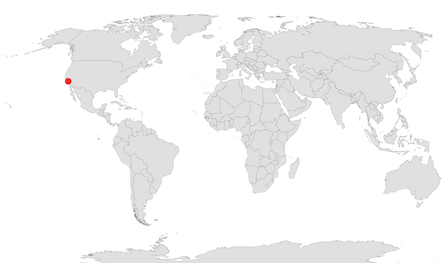

This Jupyter Notebook explores UAVSAR data over the 2017 La Tuna Fire in Los Angeles, California. Click on the underlined titles below to navigate to their section. The content of this notebook is as follows:

0. [Import Python Packages and Authenticate Notebook and data ](#s1)
1. [UAVSAR RGB Composite of La Tuna Fire](#s2)
2. [Create and Plot HV Transects](#s3)
3. [Time Series (dB)](#s4)


<a name="s1"></a>
## Running the Notebook
- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**. 
- Code cells that are required for the notebook to run without errors are marked numerically with <font color='red'> Run cell below </font> 

### Python Packages:
This routine uses the following python libraries. Some are already included in the Google Colab environment and others are installed in the cell below before imported. Downloading new python packages to this environment may take a few minutes to complete.

<font color='red'> 1. Run cell below </font> 

In [ ]:
## The packages will take around a minute to install
!pip install rasterio --quiet
!pip install rasterstats --quiet
!pip install --upgrade geopandas --quiet 
!pip install rioxarray --quiet

import rasterio as rio
import rasterio.plot
from rasterio.plot import show
import rasterstats as rs
from rasterio.plot import plotting_extent
from rasterio.mask import mask
from rasterio.merge import merge

import rioxarray #as rxr ## gdal Readasarray equivalent

import geopandas as gpd
import pandas as pd
from geopandas import GeoDataFrame

from shapely.geometry import Point
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
import plotly.graph_objects as go

import numpy as np
from pathlib import Path
from skimage.measure import profile_line
import math

#stats
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.metrics import r2_score

<a name="s2"></a>
# 1. Download Files

# UAVSAR RGB Composite of La Tuna Fire
The RGB UAVSAR images below show the September 2017 La Tuna Fire in the Verdugo Mountains, Los Angeles, California. The UAVSAR flightline SanAnd_08525 was acquired October 23, 2014 (Pre-fire) and November 02, 2017 (Post-fire). The fire perimeter extent is overlaid in red.

(Pre-Fire Top) 2014 Product Page: 
https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_14158_003_141023_L090_CX_01#data & SanAnd_26526

(Post-Fire Bottom) 2017 Product Page: 
https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_17122_003_171102_L090_CX_01#data & SanAnd_26526


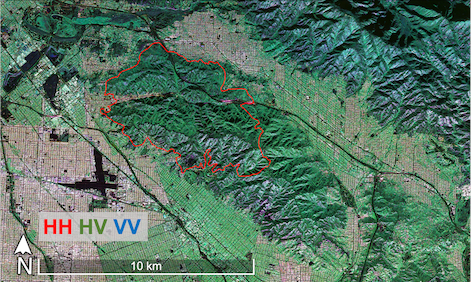

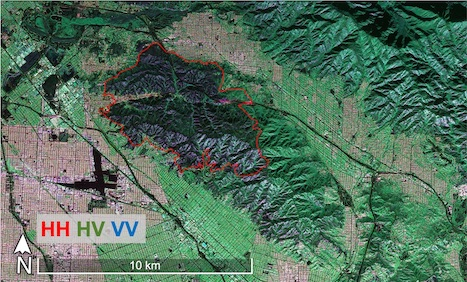

To directly compare, the UAVSAR HV log ratio and the BAER fire severity products, we will need to directly align the two datasets. This can be achieved by resampling the UAVSAR data from 6 meter to 30 meter resolution, to make BAER.

In [ ]:
## UAVSAR Geotiffs
# These are merged UAVSAR lines SanAnd_08525 & SanAnd_26526, masked for low and high local incidence angles
# 6 meter pixel size
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/HV_2014_6m.tif  --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/HV_2017_6m.tif  --quiet
# 30 meter pixel size
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/HV_2014_30m.tif  --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/HV_2017_30m.tif  --quiet

# Keep/Add in other years? 2018-2021

# USGS BAER Severity Products
BAER Products originally downloaded from: https://burnseverity.cr.usgs.gov/viewer/?product=BAER

Fire perimeter downloaded from the NIFC: https://data-nifc.opendata.arcgis.com/datasets/historic-perimeters-2017/explore

The "not burned" geojson of the Verdugo Mountains was hand traced.

In [ ]:
## BARC Products
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/dnbr_6m.tif --quiet # 6 meter
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/dnbr_30m.tif --quiet # 30 meter

## Perimeters
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/latuna_perimeter.geojson --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/unburnt_verdugo.geojson --quiet

## Rasterized version of masks in stack
# inside fire, outside fire scar, etc. 
#!wget

In [ ]:
# create data stack for 6m and 30m (in another notebook). Only read in 2 geotiff data stacks. 

# open stack (see in another notebook stack creation)

<a name="s3"></a>
## 2. Read in Files & Mask Burned and Not Burned Areas
Use rasterio to open UAVSAR Data and geopandas to read in perimeter geojsons. Create separate masks of "burned" and "not burned" areas using geojsons of the fire perimeter and the unburned portion of the Verdugo Mountains.

In [ ]:
# Read in geojson files of the fire perimeter and the not burned portion of the Verdugo Mountains
# GeoJsons
fire_perimeter = gpd.read_file('latuna_perimeter.geojson')
unburnt_perimeter = gpd.read_file('unburnt_verdugo.geojson')
perimeter = fire_perimeter["geometry"]
notburned = unburnt_perimeter["geometry"]

In [ ]:
# Do we need the meta?
# Should set to np.nan?

########## UAVSAR 6 meter#############
# Using a raster as a source, mask to the burned and not burned portions of the Verdugo Mountains
with rio.open("HV_2014_6m.tif") as hv2014_6m:
   hv2014_burned, hv2014_burned_transform = rasterio.mask.mask(hv2014_6m, perimeter, nodata=-9999, crop=False)
   hv2014_notburned, hv2014_notburned_transform = rasterio.mask.mask(hv2014_6m, notburned, nodata=-9999, crop=False)
   hv2014_full = hv2014_6m.read(1)
   hv2014_burned[hv2014_burned==-9999]=np.nan
   hv2014_notburned[hv2014_notburned==-9999]=np.nan
with rio.open("HV_2017_6m.tif") as hv2017_6m:
   hv2017_burned, hv2017_burned_transform = rasterio.mask.mask(hv2017_6m, perimeter, nodata=-9999, crop=False)
   hv2017_notburned, hv2017_notburned_transform = rasterio.mask.mask(hv2017_6m, notburned, nodata=-9999, crop=False)
   hv2017_full = hv2017_6m.read(1)
   hv2017_burned[hv2017_burned==-9999]=np.nan
   hv2017_notburned[hv2017_notburned==-9999]=np.nan
   #hv_6m_meta = hv2017_6m.meta
########## UAVSAR 30 meter#############
with rio.open("HV_2014_30m.tif") as hv2014_30m:
   hv2014_burned_30m, hv2014_burned_transform_30m = rasterio.mask.mask(hv2014_30m, perimeter, nodata=-9999, crop=False)
   hv2014_notburned_30m, hv2014_notburned_transform_30m = rasterio.mask.mask(hv2014_30m, notburned, nodata=-9999, crop=False)
   hv2014_burned_30m[hv2014_burned_30m==-9999]=np.nan
   hv2014_notburned_30m[hv2014_notburned_30m==-9999]=np.nan
with rio.open("HV_2017_30m.tif") as hv2017_30m:
   hv2017_burned_30m, hv2017_burned_transform_30m = rasterio.mask.mask(hv2017_30m, perimeter, nodata=-9999, crop=False)
   hv2017_notburned_30m, hv2017_notburned_transform_30m = rasterio.mask.mask(hv2017_30m, notburned, nodata=-9999, crop=False)
   hv2017_burned_30m[hv2017_burned_30m==-9999]=np.nan
   hv2017_notburned_30m[hv2017_notburned_30m==-9999]=np.nan
   #hv_30m_meta = hv2017_30m.meta
########## dNBR #############
with rio.open("dnbr_30m.tif") as dnbr_30m:
   dnbr_burned_30m, dnbr_burned_transform_30m = rasterio.mask.mask(dnbr_30m, perimeter, nodata=-9999, crop=False)
   dnbr_notburned_30m, notburned_transform_30m = rasterio.mask.mask(dnbr_30m, notburned, nodata=-9999, crop=False)
   dnbr_burned_30m[dnbr_burned_30m==-9999]=np.nan
   dnbr_notburned_30m[dnbr_notburned_30m==-9999]=np.nan
   #dnbr_30m_meta = dnbr_30m.meta
with rio.open("dnbr_6m.tif") as dnbr_6m:
   dnbr_burned_6m, dnbr_burned_transform_6m = rasterio.mask.mask(dnbr_6m, perimeter, nodata=-9999, crop=False)
   dnbr_notburned_6m, notburned_transform_6m = rasterio.mask.mask(dnbr_6m, notburned, nodata=-9999, crop=False)
   dnbr_burned_6m[dnbr_burned_6m==-9999]=np.nan
   dnbr_notburned_6m[dnbr_notburned_6m==-9999]=np.nan
   #dnbr_6m_meta = dnbr_6m.meta

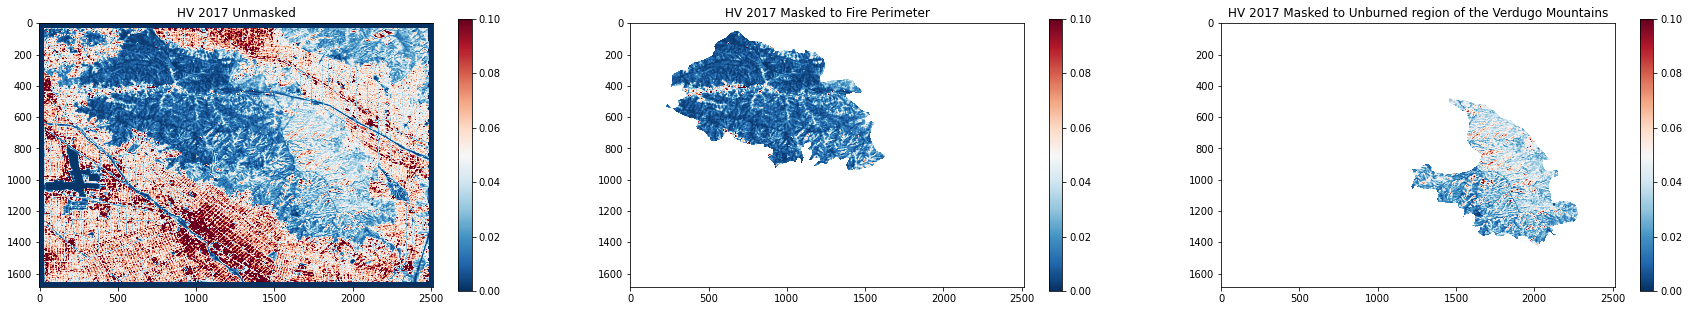

In [ ]:
# Plot Masked
fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))

vmin = 0
vmax = 0.1

## Add Verdugo Fire Scar & get rid of other 2 plots
## Add 2014, to compare 2014 & 2017

cmap = "RdBu_r"
plot = ax1.imshow(hv2017_full.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap)
ax1.set_title('HV 2017 Unmasked')
fig.colorbar(plot, ax=ax1, shrink=0.5)

plot = ax2.imshow(hv2017_burned.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap)
ax2.set_title('HV 2017 Masked to Fire Perimeter')
fig.colorbar(plot, ax=ax2, shrink=0.5)

plot = ax3.imshow(hv2017_notburned.squeeze(),vmin=vmin, vmax=vmax, cmap=cmap)
ax3.set_title('HV 2017 Masked to Unburned region of the Verdugo Mountains')
fig.colorbar(plot, ax=ax3, shrink=0.5)

<a name="s3"></a>
## 3. Calculate the HV Log Ratio
Below is a transect over the Verdugo mountains, spanning burned and unburned regions of the mountain range after the September 2017 La Tuna Fire. UAVSAR's HV polarization is used due to HV's sensitivity to vegetation change and transects from images pre and post fire can be uesd compare changes in HV backscatter values between areas burnt in the fire and unburnt areas. Burnt areas should have decreased HV backscatter.



Calculate and plot the HV/HV log ratio for pre and post fire UAVSAR acquisitions. 

Source: pg 116 https://gis1.servirglobal.net/TrainingMaterials/SAR/SARHB_FullRes.pdf </font> 



In [ ]:
# Find the HV log ratio between 2014 and 2017 UAVSAR acquisitions
# 6 meter
HV_log_2014_2017_burned_6m = np.log(np.divide(hv2014_burned, hv2017_burned))
HV_log_2014_2017_notburned_6m = np.log(np.divide(hv2014_notburned, hv2017_notburned))
# HV_log_2014_2017_6m = HV_log_2014_2017_6m.squeeze()
# 30 meter
HV_log_2014_2017_burned_30m = np.log(np.divide(hv2014_burned_30m, hv2017_burned_30m))
HV_log_2014_2017_notburned_30m = np.log(np.divide(hv2014_notburned_30m, hv2017_notburned_30m))
# HV_log_2014_2017_30m = HV_log_2014_2017_30m.squeeze()
# Unmasked ratio
HV_log_2014_2017_full = np.log(np.divide(hv2014_full, hv2017_full))

Plot the HV log ratio for 2014/2017 in 6 meter and 30 meter pixel size

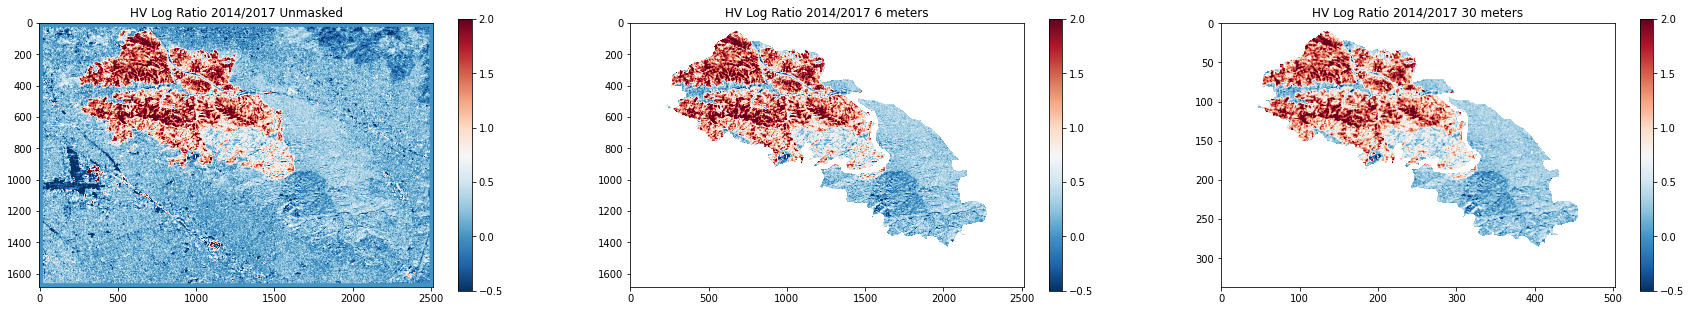

In [ ]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))

vmin = -0.5
vmax = 2

cmap = "RdBu_r"
plot = ax1.imshow(HV_log_2014_2017_full.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap)
ax1.set_title('HV Log Ratio 2014/2017 Unmasked')
fig.colorbar(plot, ax=ax1, shrink=0.5)

plot = ax2.imshow(HV_log_2014_2017_burned_6m.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap)
ax2.imshow(HV_log_2014_2017_notburned_6m.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap)
ax2.set_title('HV Log Ratio 2014/2017 6 meters')
fig.colorbar(plot, ax=ax2, shrink=0.5)

plot = ax3.imshow(HV_log_2014_2017_burned_30m.squeeze(),vmin=vmin, vmax=vmax, cmap=cmap)
ax3.imshow(HV_log_2014_2017_notburned_30m.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap)
ax3.set_title('HV Log Ratio 2014/2017 30 meters')
fig.colorbar(plot, ax=ax3, shrink=0.5)

<a name="s3"></a>
## 4. UAVSAR & dNBR Comparison


Plot and inspect BAER data. The stripes in the dNBR is due to issues with Landsat 7. We will look at the officially released fire severity product.


Here, instead aim to have low res UAVSAR, 30 meter UAVSAR, and dNBR all side by side. Two UAVSAR (low and high res) scaled the same.

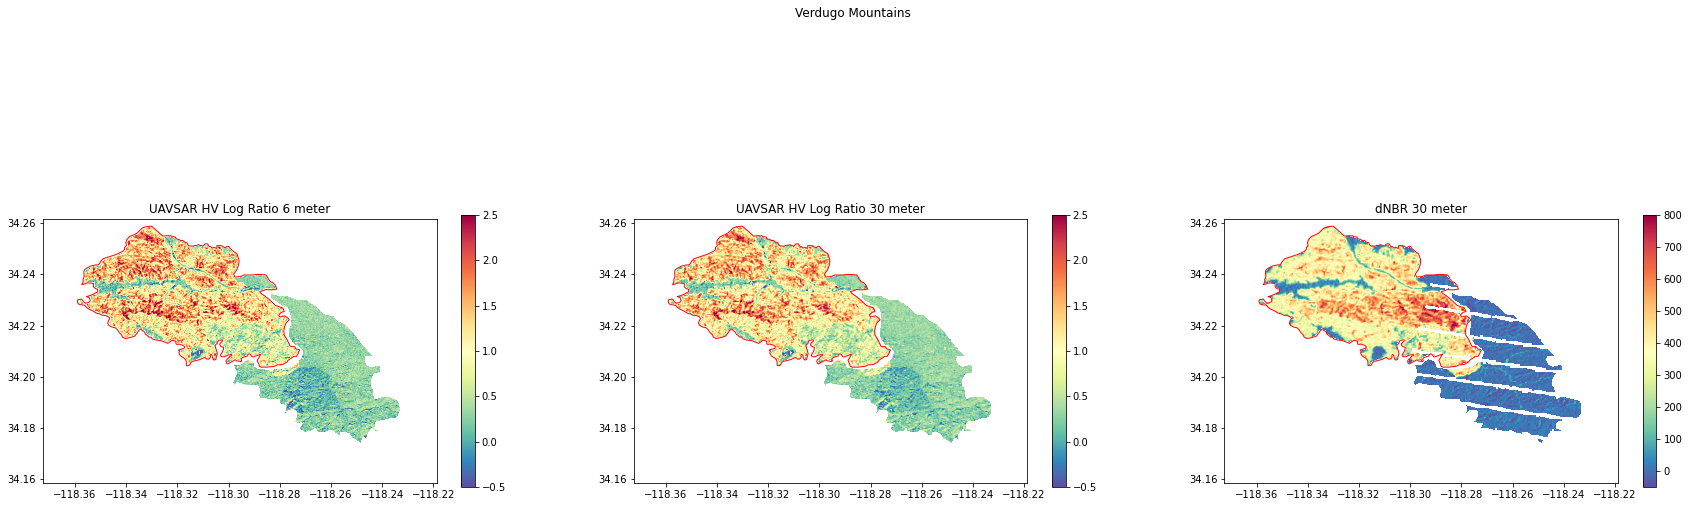

In [ ]:
#@title Plot UAVSAR HV Log Ratio & dNBR

### BREAK UP CELL 
# 1) Find threshold and plot histogram 
# 2) Masking the map
# 3) Prep to overlay perimeter
# 4) Making the map

fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize=(30,10))

# Add fire perimeters
# Read in fire perimeter
with rio.open('HV_2014_6m.tif') as subset_src: #getting reference extent
    subset_extent = plotting_extent(subset_src)
    trans = subset_src.transform
fire_boundary = perimeter.to_crs(subset_src.crs)
fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax1)
fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax2)
fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax3)

# Add general map title
fig.suptitle('Verdugo Mountains')
# Map vis parameters
cmap = "Spectral_r"
vmin = -0.5
vmax = 2.5
args = dict(vmin=vmin, vmax=vmax, cmap=cmap, extent=subset_extent)

# Plot UAVSAR 6 meter
ax1.imshow(HV_log_2014_2017_burned_6m.squeeze(), **args)
plot = ax1.imshow(HV_log_2014_2017_notburned_6m.squeeze(), **args)
ax1.set_title("UAVSAR HV Log Ratio 6 meter")
fig.colorbar(plot, ax=ax1, shrink=0.5)

# Plot UAVSAR 30 meter
ax2.imshow(HV_log_2014_2017_burned_30m.squeeze(), **args)
plot = ax2.imshow(HV_log_2014_2017_notburned_30m.squeeze(), **args)
ax2.set_title("UAVSAR HV Log Ratio 30 meter")
fig.colorbar(plot, ax=ax2, shrink=0.5)

# Plot dNBR 30 meter
ax3.imshow(dnbr_burned_30m.squeeze(), vmin=-50, vmax=800, cmap=cmap, extent=subset_extent)
plot = ax3.imshow(dnbr_notburned_30m.squeeze(), vmin=-50, vmax=800, cmap=cmap, extent=subset_extent)
ax3.set_title("dNBR 30 meter")
fig.colorbar(plot, ax=ax3, shrink=0.5)

## UAVSAR & dNBR Histograms

Thresholding the histograms. Finding the area under the curve. Looking to find the 95th percentile of the not burned area.

In [ ]:
# Function to find the area under the curve & plot a line
def area_under_curve(axes, bins, value, counts, color):
  # Find bin corresponding to percent value
  array = np.asarray(value)
  # Return indices of bins of array value
  index = np.digitize(array, bins) - 1
  # Calculate area under hist after value
  bin_width = np.diff(bins)[0]
  area = sum(bin_width * counts[:index])
  # Add area line
  axes.axvline(value, color=color, label=f"Val={value:.2f}, Area={area:.2f}")
  axes.legend()

# Function to find the index for a specific area under the histogram's curve
def area(bins, height, value):
  # Find width of histogram bins
  bin_width = np.diff(bins)[0]
  # Get the area of each bin
  area = height * bin_width
  # Find the cumulative sum of the bins
  cumsum = np.cumsum(area)
  # Find the bin index where the cumulative area equals the input value
  array = np.asarray(value)
  index = np.digitize(array, cumsum)
  print("The threshold for " + str(value) + " percentile under the curve is: " + str(bins[index]))

The threshold for 0.95 percentile under the curve is: 1.035
The threshold for 0.9 percentile under the curve is: 2.205
The threshold for 0.95 percentile under the curve is: 0.54
The threshold for 0.9 percentile under the curve is: 1.845
The threshold for 0.95 percentile under the curve is: 68.90083
The threshold for 0.9 percentile under the curve is: 578.4077


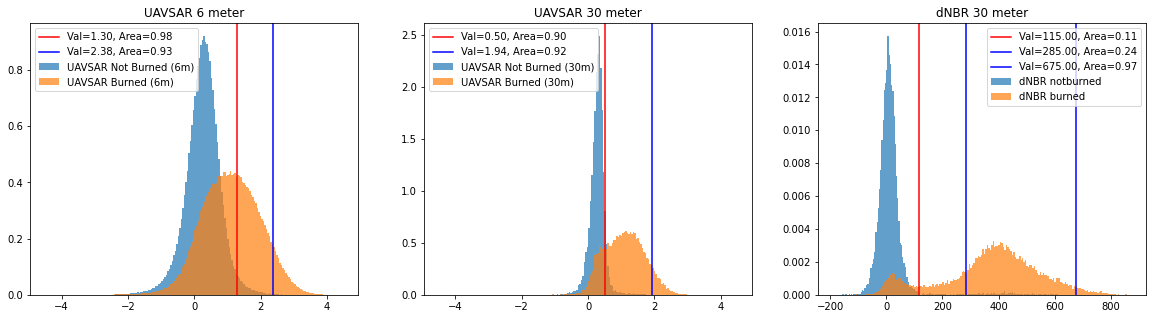

In [ ]:
fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize=(20,5))

######################### Histograms ######################### 
########## UAVSAR 6 meter#############
n_notburned, bins_notburned, patches_notburned = ax1.hist(HV_log_2014_2017_notburned_6m.flatten(), range = [-4.5, 4.5], bins=200, alpha=0.7, density=True,label='UAVSAR Not Burned (6m)')
n_burned, bins_burned, patches_burned = ax1.hist(HV_log_2014_2017_burned_6m.flatten(), bins=200, range = [-4.5, 4.5], alpha=0.7, density=True, label='UAVSAR Burned (6m)')
ax1.set_title("UAVSAR 6 meter")

# Find threshold for top 5% of the not burned area
area(bins_notburned, n_notburned, 0.95)
# Find threshold for top 10% of the not burned area
area(bins_burned, n_burned, 0.90)

# Plot a line showing threshold for not burned 0.95
area_under_curve(ax1, bins_notburned, 1.305, n_notburned, color="r")
# Plot a line showing threshold for burned 0.95
area_under_curve(ax1, bins_burned, 2.385, n_burned, color="b")

########## UAVSAR 30 meter#############
n_notburned, bins_notburned, patches_notburned = ax2.hist(HV_log_2014_2017_notburned_30m.flatten(),range = [-4.5, 4.5], bins=200, alpha=0.7, density=True, label='UAVSAR Not Burned (30m)')
n_burned, bins_burned, patches_burned = ax2.hist(HV_log_2014_2017_burned_30m.flatten(), range = [-4.5, 4.5],bins=200, alpha=0.7, density=True, label='UAVSAR Burned (30m)')
ax2.set_title("UAVSAR 30 meter")

# Find threshold for top 5% of the not burned area
area(bins_notburned, n_notburned, 0.95)
# Find threshold for top 10% of the burned area
area(bins_burned, n_burned, 0.90)

# Plot a line showing threshold for not burned 0.95
area_under_curve(ax2, bins_notburned, 0.5, n_notburned, color="r")
# Plot a line showing threshold for burned 0.95
area_under_curve(ax2, bins_burned, 1.935, n_burned, color="b")

########## dNBR 30 meter#############
n_notburned, bins_notburned, patches_notburned = ax3.hist(dnbr_notburned_30m.flatten(), bins=200, alpha=0.7, density=True,label="dNBR notburned")
n_burned, bins_burned, patches_burned = ax3.hist(dnbr_burned_30m.flatten(), bins=200, alpha=0.7, density=True,label="dNBR burned")
ax3.set_title("dNBR 30 meter")

# Find threshold for top 5% of the not burned area
area(bins_notburned, n_notburned, 0.95)
# Find threshold for top 10% of the burned area
area(bins_burned, n_burned, 0.90)

# dNBR low burn threshold
area_under_curve(ax3, bins_burned, 115, n_burned, color="r")
# dNBR moderate burn threshold
area_under_curve(ax3, bins_burned, 285, n_burned, color="b")
# dNBR high burn threshold
area_under_curve(ax3, bins_burned, 675, n_burned, color="b")

In [ ]:
# From above plots, general agreement of HV log ratio and dNBR burned & unburned areas.
# Not paired t-test to test for statistical significance
# Correspondence bewteen moderate & high severity? Can this be captured with UAVSAR?
# For dNBR, see one clear area of high severity, while UAVSAR seems to show two areas of high severity. 
# One area of disagreemnt in North (UAVSAR high intensity) and East (dNBR high intensity)

 Process_Description:
        These data products are derived from Landsat 8 data. Pre-fire and post-fire scenes are analyzed to create a differenced Normalized Burn Ratio (dNBR) image. The dNBR image portrays the variation of burn severity within the fire. The pre- and post-fire Landsat images are terrain corrected and corrected to Top of Atmosphere reflectance. The Normalized Burn Ratio (NBR) is computed for each date of imagery (Landsat 8 bands) using the following formula: 
        (Band 5(NIR) - Band 7(SWIR) / (Band 5 + Band 7) = NBR

        The Differenced NBR is computed to determine severity by subtracting the post-fire NBR from the pre-fire NBR:
        (PreNBR - PostNBR) = dNBR

        The BARC products are a generalization of the raw dNBR dataset. Both BARC products have been resampled to unsigned 8-bit images and are easily viewed and adjusted within ArcGIS.

        The classes represented on the BARC products are created with thresholds chosen by an analyst at USGS EROS.  These thresholds can be roughly related back to original dNBR values by multiplying by 5 and then subtracting 275 (for example, a BARC256 value of 100 would relate to a dNBR value of 225).  The thresholds used on this particular fire are:
   
	Unchanged:	All values    0 - 77
	Low:		All values   78 - 111
	Moderate:	All values  112 - 189
	High:		All values  190 - 255
	No Data/Clouds:	All values    



Unchanged:
* (0 * 5) - 275 = -275
* (77 * 5) - 275 = 110

Low:
* (78 * 5) - 275 = 115
* (111 * 5) - 275 = 280

Moderate:
* (112 * 5) - 275 = 285
* (189 * 5) - 275 = 670

High:
* (190 * 5) - 275 = 675
* (255 * 5) - 275 = 1000


So dnBR thresholds are: 115, 285, 675




## UAVSAR 30 meter vs 6 meters

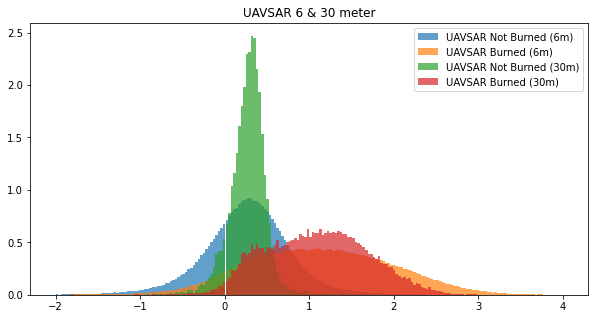

In [ ]:
# Comparing UAVSAR 6 meter and 30 meter resolutions
fig, (ax1)  = plt.subplots(1,1, figsize=(10,5))
min = -2
max = 4
kwargs = dict(range = [min, max], bins=200, alpha=0.7, density=True)
########## UAVSAR 6 meter#############
n_notburned, bins_notburned, patches_notburned = ax1.hist(HV_log_2014_2017_notburned_6m.flatten(), **kwargs, label='UAVSAR Not Burned (6m)')
n_burned, bins_burned, patches_burned = ax1.hist(HV_log_2014_2017_burned_6m.flatten(), **kwargs, label='UAVSAR Burned (6m)')
########## UAVSAR 30 meter#############
n_notburned, bins_notburned, patches_notburned = ax1.hist(HV_log_2014_2017_notburned_30m.flatten(), **kwargs, label='UAVSAR Not Burned (30m)')
n_burned, bins_burned, patches_burned = ax1.hist(HV_log_2014_2017_burned_30m.flatten(), **kwargs, label='UAVSAR Burned (30m)')
ax1.set_title("UAVSAR 6 & 30 meter")
ax1.legend()

## Stack UAVSAR & dNBR

In [ ]:
x = HV_log_2014_2017_burned_6m.squeeze()
y = dnbr_burned_6m.squeeze() # dNBR has more masked areas due to data striping
# x = x[~np.isnan(y)]
# y = y[~np.isnan(y)]

In [ ]:
print(x.shape)

(1684, 2516)


In [ ]:
print(y.shape)

(1684, 2516)


In [1]:
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=5)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='red')
plt.xlabel('dNBR')
plt.ylabel('HV Log Ratio')
plt.title('HV Log Ratio 2014/2017 vs dNBR in Burned Areas')
ax.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0,3))
plt.show()

## separate R-squared plot and threshold lines into 2 side-by-side plots
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=5)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
# plt.plot(x, m*x+b, color='red')
plt.axvline(x = 200, color = 'b', label = 'dNBR threshold')
plt.axhline(y = 0.6, color = 'b', label = 'HV threshold')
plt.xlabel('dNBR')
plt.ylabel('HV Log Ratio')
plt.title('HV Log Ratio 2014/2017 vs dNBR in Burned Areas')
ax.annotate("Pearson's R = {:.3f}".format(x.corr(y)), (0,3)) ## r2_score large negative result
# https://realpython.com/numpy-scipy-pandas-correlation-python/
plt.show()


### Make same plot, looking specifically at high fire severity for UAVSAR & dNBR
# uncertainties - UAVSAR high, dNBR moderate & dNBR high, UAVSAR low
# map these & map interpretation with google earth 


# Replot at 6 meters

# New plot with all of the Verdugo Mountains

In [ ]:
# Separate into 4 classes depending on threshold
thresh_dnbr = 200
thresh_hv = 1.3

hv = HV_log_2014_2017_burned_6m
dnbr = dnbr_burned_6m
hv_reclass = HV_log_2014_2017_burned_6m

# Low Burned Agreement: Less than HV & dNBR Threshold
hv_reclass[np.where((hv <= thresh_hv)& (dnbr <= thresh_dnbr))] = 10
# Low Burn UAVSAR, Burn dNBR
hv_reclass[np.where((hv <= thresh_hv) & (dnbr >= thresh_dnbr))] = 20
# Burn UAVSAR, Low Burn dNBR
hv_reclass[np.where((hv >= thresh_hv) & (dnbr <= thresh_dnbr))] = 30
# Burn UAVSAR, Burn dNBR
hv_reclass[np.where((hv >= thresh_hv) & (dnbr >= thresh_dnbr))] = 40
hv_reclass[np.where(hv_reclass < 10)] = np.nan

In [ ]:
with rasterio.open('reclassified.tif', 'w', **profile) as dst:
  dst.write(hv_reclass.squeeze().astype(rasterio.float64), 1)

In [ ]:
plt.imshow(hv_reclass)

Boxplot

HV log ratio & BAER Burn Severity

In [ ]:
# # Box plot. For dNBR "burned" and "unburned", show HV_spread
# boxplot = masked.boxplot(column=['hv_burned','hv_notburned'], whis=[5, 95], showfliers=False) #this whisker paramter is a percentile
# boxplot.plot()

# plt.xticks([1, 2], ['Burned', 'Not Burned'])
# plt.title('HV Log Ratio 2014/2017 over the Verdugo Mountains')
# plt.show()


## Change whiskers to 2 stdDev and box to 1
## Annotate mean and stdDev values if possible... saw ann example of this

T-test - testing for statistically different means between two groups

In [ ]:
# import scipy.stats as stats
# # T-Test UAVSAR
# # Perform the two sample t-test with equal variances
# stats.ttest_ind(a=masked['hv_burned'].dropna(), b=masked['hv_notburned'].dropna(), equal_var=True)

# # T-Test dNBR
# stats.ttest_ind(a=masked['dnbr_burned'].dropna(), b=masked['dnbr_notburned'].dropna(), equal_var=True)

The BARC published dNBR uses a mix of Landsat 7 & Landsat 8. 

Potential Issues:
* Cross instrument appropriately calibrated / accounted for?
* No data stripes (issue with Landsat 7 platform)
* The published BARC product uses 08/28/17 & 09/05/2017 images. However, the La Tuna fire burned for a few days after - until 09/09/2017

Proposed investigation with GEE Python API:
* Use Landast 8 for both input images to dNBR
* Try a Landsat 8 range with same 08/28/17 with the next L8 acquisition over the Verdugos
* Could also try dNBR matching UAVSAR collection dates...


Next, convert to decibels (dB)

<font color='red'> 4. Run cell below </font> 

In [ ]:
## Convert to from linear power to decibels (dB)
## Formula: 10*log10(DN)
def convert_db(data):
  db = 10*(math.log10(data))
  return db

convert_db2 = np.vectorize(convert_db)

HV2014 = convert_db2(HV2014)
HV2017 = convert_db2(HV2017)

Then, specify pixel coordinates and transect width with "linewidth" and transect output values with "reduce_func"

<font color='red'> 5. Run cell below </font> 

In [ ]:
# Specify pixel coordinates
x0, y0 = 1300, 700
x1, y1 = 2200, 1300

# Specify transect
transect_2014 = profile_line(HV2014, (y0, x0), (y1, x1), linewidth=10, mode='nearest')#, reduce_func=np.median)
transect_2017 = profile_line(HV2017, (y0, x0), (y1, x1), linewidth=10, mode='nearest')#, reduce_func=np.median)

Finally, plot 2014 and 2017 data and transect

<font color='red'> 6. Run cell below </font> 

In [ ]:
#@title 2014 and 2017 decibel images and transect charts
# with rio.open('SanAnd_08525_14158_003_141023_L090HHHH_CX_01_cropped.grd.tif') as subset_src:
#     subset_extent = plotting_extent(subset_src)

# top_left_lon = -118.3907205000000147
# top_left_lat = 34.2716026200000101
# extent_mat = (top_left_lon, top_left_lon + subset_src.shape[1] * 0.00005556000000000000337, 
#               top_left_lat - subset_src.shape[0] * 0.00005556000000000000337, top_left_lat)

############## 2014 ##############
cm = ['viridis']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
color = axes[0,0].imshow(HV2014, vmin=-30, vmax=-5, cmap=cm[0])#, extent=extent_mat) 
axes[0,0].plot([x0, x1], [y0, y1], 'ro-', lw=10)
axes[0,0].set_title('HV 2014 (Pre-Fire)')
fig.colorbar(color, ax=axes[0,0])

axes[0,1].plot(transect_2014, color='orange', linewidth='1')
axes[0,1].set_ylim([-35, -5])
axes[0,1].set_title('HV 2014 Transect')

############## 2017 ##############
color = axes[1,0].imshow(HV2017, vmin=-30, vmax=-5, cmap=cm[0])#, extent=extent_mat)
axes[1,0].plot([x0, x1], [y0, y1], 'ro-', lw=10)
axes[1,0].set_title('HV 2017 (Post-Fire)')
fig.colorbar(color, ax=axes[1,0])

axes[1,1].plot(transect_2017, color='red', linewidth='1')
axes[1,1].plot(transect_2014, color='orange', linewidth='0.5')
axes[1,1].set_ylim([-35, -5])
axes[1,1].set_title('HV 2017 Transect')
plt.legend(('2017 Post-Fire', '2014 Pre-Fire'),
           loc='upper right')

plt.show()

## Data Download
UAVSAR Download: https://uavsar.jpl.nasa.gov/cgi-bin/data.p

ASF: https://search.asf.alaska.edu/#/

## Other Resources
NISAR Fire Applications White Paper: https://nisar.jpl.nasa.gov/system/documents/files/13_NISAR_Applications_Fire_Management1.pdf

ESA Document on Polarimetric Decompositions: https://earth.esa.int/documents/653194/656796/Polarimetric_Decompositions.pdf

Polarimetry: https://nisar.jpl.nasa.gov/mission/get-to-know-sar/polarimetry/

## References
“La Tuna Fire, City's Biggest by Acreage, Now 80% Contained, Officials Say.” Los Angeles Times, Los Angeles Times, 6 Sept. 2017, www.latimes.com/local/lanow/la-me-ln-verdugo-fire-containment-20170905-story.html.

Donnellan, Andrea, et al. “UAVSAR and Optical Analysis of the Thomas Fire Scar and Montecito Debris Flows: Case Study of Methods for Disaster Response Using Remote Sensing Products.” Earth and Space Science, vol. 5, no. 7, 2018, pp. 339–347., doi:10.1029/2018ea000398.

Ban, Y. et al. (2020) Near Real-Time Wildfire Progression Monitoring with Sentinel-1 SAR Time Series and Deep Learning. Nature Scientific Reports, 10 (1322).

California EPA (2021, January 8) Governor’s task force outlines actions to reduce wildfire rish, improve health of forests and wildlands. Accessed February 1, 2021.

Czuchlewski, K.R. and Weissel, J. K. (2005) Synthetic aperture radar (SAR)-based mapping of wildfire burn severity and recovery. Proceedings: 2005 IEEE International Geoscience and Remote Sensing Symposium.

Jung, J., et al. (2018) Damage-Mapping Algorithm Based on Coherence Model Using Multitemporal Polarimetric-Interferometric SAR Data. IEEE Transactions on Geoscience and Remote Sensing 56, 1520–1532.

NASA EarthData (2020, April 16) What is synthetic aperture radar? Accessed February 1, 2021.

NASA Jet Propulsion Laboratory (2021) What is UAVSAR? Accessed February 1, 2021.

NASA Jet Propulsion Laboratory (2020, September 15) NASA Takes Flight to Study California’s Wildfire Burn Areas. Accessed February 1, 2021.

Parker, J., Donnellan, A., & Glasscoe, M. (2021) Survey of Transverse Range Fire Scars in Ten Years of UAVSAR Polarimetry. Wiley.

Rains C. (2019) Detection of Fire Burn Scars by UAVSAR: Immediate, Short-term, and Multi-year Observations and Applications. NASA presentation.

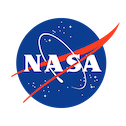

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2021. California Institute of Technology. Government sponsorship acknowledged. 